# Петар и вук: Реалистично окружење

У нашој ситуацији, Петар је могао да се креће готово без умора или глади. У реалистичнијем свету, морао би с времена на време да седне и одмори се, као и да се нахрани. Хајде да учинимо наш свет реалистичнијим, применом следећих правила:

1. Крећући се са једног места на друго, Петар губи **енергију** и добија одређени ниво **умора**.
2. Петар може да повећа енергију једући јабуке.
3. Петар може да се ослободи умора одмарајући се испод дрвета или на трави (тј. уласком на локацију табле са дрветом или травом - зелено поље).
4. Петар мора да пронађе и убије вука.
5. Да би убио вука, Петар мора да има одређене нивое енергије и умора, иначе губи битку.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

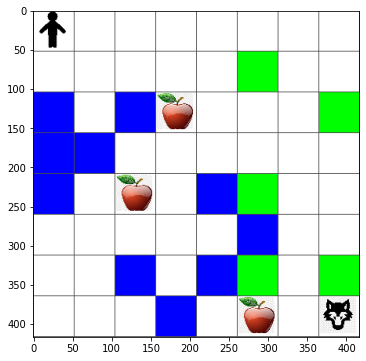

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Дефинисање стања

У нашим новим правилима игре, потребно је да пратимо енергију и умор у сваком стању табле. Због тога ћемо креирати објекат `state` који ће носити све потребне информације о тренутном стању проблема, укључујући стање табле, тренутне нивое енергије и умора, и да ли можемо победити вука у терминалном стању:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Хајде да покушамо да решимо проблем користећи случајну шетњу и видимо да ли ћемо успети:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Функција награде

Функција награде је кључни део система за учење заснованог на награђивању. Она дефинише како агент добија повратне информације за своје акције у окружењу.

### Основни принципи

- Функција награде треба да буде једноставна и интуитивна.
- Треба да подстиче жељено понашање агента.
- Избегавајте сложене математичке изразе који могу довести до неочекиваних резултата.

[!NOTE] Увек тестирајте функцију награде у симулацији пре него што је примените у стварном окружењу.

### Пример

Ево једноставног примера функције награде:

```python
def reward_function(params):
    if params['is_off_track']:
        return -10  # Казна за излазак са стазе
    elif params['is_near_center']:
        return 5  # Награда за кретање близу центра
    else:
        return 1  # Мала награда за кретање по стази
```

### Савети за креирање функције награде

[!TIP] Почните са основним правилима и постепено додајте сложеност.

- Користите параметре као што су брзина, позиција и оријентација за израчунавање награде.
- Увек узмите у обзир крајњи циљ агента.

[!WARNING] Превише сложена функција награде може довести до проблема са учењем.

### Честа питања

#### Шта ако агент не учи како треба?

Проверите да ли функција награде правилно одражава жељено понашање. Можда је потребно да прилагодите вредности награда и казни.

#### Могу ли користити више функција награде?

Да, можете комбиновати више функција награде како бисте постигли сложеније циљеве. Међутим, будите опрезни да не створите конфликте између различитих функција.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning алгоритам

Сам алгоритам учења остаје углавном непромењен, само користимо `state` уместо само позиције на табли.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

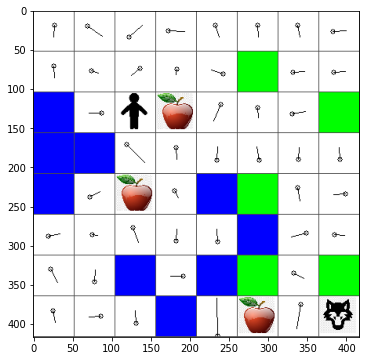

In [11]:
m.plot(Q)

## Резултати

Хајде да видимо да ли смо успешно обучили Петра да се бори против вука!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Сада видимо много мање случајева дављења, али Петар још увек није увек у стању да убије вука. Покушајте да експериментишете и видите да ли можете побољшати овај резултат играјући се са хиперпараметрима.


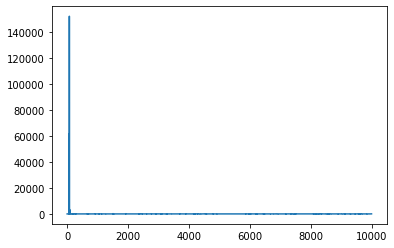

In [13]:
plt.plot(lpath)


---

**Одрицање од одговорности**:  
Овај документ је преведен коришћењем услуге за превођење помоћу вештачке интелигенције [Co-op Translator](https://github.com/Azure/co-op-translator). Иако се трудимо да обезбедимо тачност, молимо вас да имате у виду да аутоматски преводи могу садржати грешке или нетачности. Оригинални документ на његовом изворном језику треба сматрати меродавним извором. За критичне информације препоручује се професионални превод од стране људи. Не преузимамо одговорност за било каква погрешна тумачења или неспоразуме који могу настати услед коришћења овог превода.
